In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from nilearn.connectome import sym_matrix_to_vec
import pandas as pd
import pingouin as pg
import seaborn as sns
from sklearn.decomposition import PCA, FastICA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (PredictionErrorDisplay, 
                             make_scorer,
                             mean_absolute_percentage_error,
                             mean_squared_error)
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
import xarray as xr

In [2]:
target_dict_hcp = {
    "PicVocab_AgeAdj": "NIHTB Vocabulary (picture matching)",
    "ReadEng_AgeAdj": "NIHTB Reading (pronunciation)",
    "WM_Task_2bk_Acc": "Working Memory (2-back)",
    "Relational_Task_Acc": "Relational processing",
    "Language_Task_Story_Acc": "Story comprehension",
    "PMAT24_A_CR": "Fluid Intelligence (PMAT)",
    "VSPLOT_TC": "Spatial orientation",  #???
    "CardSort_AgeAdj": "NIHTB Cognitive Flexibility (DCCS)",
    "PMAT24_A_CR": "Fluid Intelligence (Penn Progressive Matrices)",
    "ProcSpeed_AgeAdj": "NIHTB Processing Speed",
    "CogFluidComp_AgeAdj":"NIHTB Cognition Fluid",
    "CogTotalComp_AgeAdj":"NIHTB Cognition Total",
    "CogCrystalComp_AgeAdj":"NIHTB Cognition Crystallized",
    "ListSort_AgeAdj": "NIHTB Working Memory (list sorting)",
    "Language_Task_Math_Acc": "Arithmetic", # ???
    "PicSeq_AgeAdj": "NIHTB Visual Episodic Memory",
    "SCPT_SPEC": "Sustained attention (Spec.)",
    "Flanker_AgeAdj": "NIHTB Inhibition (Flanker Task)",

    "AngAffect_Unadj": "NIHTB Anger",
    "AngHostil_Unadj": "NIHTB Hostility & Cynicism",
    "AngAggr_Unadj": "NIHTB Physical Aggression",
    "FearAffect_Unadj": "NIHTB Fear",
    "FearSomat_Unadj": "NIHTB Somatic Arousal",
    "Sadness_Unadj": "NIHTB Sadness",
    "LifeSatisf_Unadj": "NIHTB Life Satisfaction",
    "MeanPurp_Unadj": "NIHTB Meaning and Purpose",
    "PosAffect_Unadj": "NIHTB Positive Affect",
    "Friendship_Unadj": "NIHTB Friendship",
    "Loneliness_Unadj": "NIHTB Loneliness",
    "PercHostil_Unadj": "NIHTB Perceived Hostility",
    "PercReject_Unadj": "NIHTB Perceived Rejection",
    "EmotSupp_Unadj": "NIHTB Emotional Support",
    "InstruSupp_Unadj": "NIHTB Instrumental Support",
    "PercStress_Unadj": "NIHTB Perceived Stress",
    "SelfEff_Unadj": "NIHTB Self-Efficacy",
    
    "Emotion_Task_Face_Acc": "Emotional Face Matching",
    "IWRD_TOT": "Verbal Episodic Memory",
    "Dexterity_AgeAdj": "Manual dexterity",
    "ER40_CR": "Emotion recognition - Total",
    "ER40SAD": "Emotion recognition - Sad",
    "ER40ANG": "Emotion recognition - Angry",
    ### SOCIAL COGNITION - INTERACTION ??????
    "ER40NOE": "Emotion recognition - Neutral",
    "MMSE_Score": "Cognitive status (MMSE)",
    "ER40HAP": "Emotion recognition - Happy",
    "SCPT_SEN": "Sustained attention (Sens.)",
    "Social_Task_Perc_Random": "Social cognition (Random)",
    "ER40FEAR": "Emotion recognition - Fear"
}

target_dict_abcd = {
    'cbcl_scr_syn_anxdep_r': 'CBCL Anxiety/Depression',
    'cbcl_scr_syn_anxdep_t': 'CBCL Anxiety/Depression',
    'cbcl_scr_syn_withdep_r': 'CBCL Withdrawn/Depressed',
    'cbcl_scr_syn_withdep_t': 'CBCL Withdrawn/Depressed',
    'cbcl_scr_syn_somatic_r': 'CBCL Somatic Complaints',
    'cbcl_scr_syn_somatic_t': 'CBCL Somatic Complaints',
    'cbcl_scr_syn_social_r': 'CBCL Social Problems',
    'cbcl_scr_syn_social_t': 'CBCL Social Problems',
    'cbcl_scr_syn_thought_r': 'CBCL Thought Problems',
    'cbcl_scr_syn_thought_t': 'CBCL Thought Problems',
    'cbcl_scr_syn_attention_r': 'CBCL Attention Problems',
    'cbcl_scr_syn_attention_t': 'CBCL Attention Problems',
    'cbcl_scr_syn_rulebreak_r': 'CBCL Rule-Breaking Behavior',
    'cbcl_scr_syn_rulebreak_t': 'CBCL Rule-Breaking Behavior',   
    'cbcl_scr_syn_aggressive_r': 'CBCL Aggressive Behavior',
    'cbcl_scr_syn_aggressive_t': 'CBCL Aggressive Behavior',
    'cbcl_scr_syn_internal_r': 'CBCL Internalizing Problems',
    'cbcl_scr_syn_internal_t': 'CBCL Internalizing Problems',
    'cbcl_scr_syn_external_r': 'CBCL Externalizing Problems',
    'cbcl_scr_syn_external_t': 'CBCL Externalizing Problems',
    'cbcl_scr_syn_totprob_r': 'CBCL Total Problems',
    'cbcl_scr_syn_totprob_t': 'CBCL Total Problems',
    'cbcl_scr_07_sct_r': 'CBCL Social Competence',
    'cbcl_scr_07_sct_t': 'CBCL Social Competence',
    'cbcl_scr_07_ocd_r': 'CBCL Obsessive-Compulsive Disorder',
    'cbcl_scr_07_ocd_t': 'CBCL Obsessive-Compulsive Disorder',
    'cbcl_scr_07_stress_r': 'CBCL Stress, raw value',
    'cbcl_scr_07_stress_t': 'CBCL Stress, t value',
    'nihtbx_picvocab_uncorrected': "Vocabulary (picture matching), uncorrected",
    'nihtbx_flanker_uncorrected': "Inhibition (Flanker Task), uncorrected",
    'nihtbx_list_uncorrected': "Working Memory (list sorting), uncorrected",
    'nihtbx_cardsort_uncorrected': "Cognitive Flexibility (DCCS), uncorrected",
    'nihtbx_pattern_uncorrected': "Processing Speed, uncorrected",
    'nihtbx_reading_uncorrected': "Reading (pronunciation), uncorrected",
    'nihtbx_fluidcomp_uncorrected': "Cognition Fluid Composite Score, uncorrected",
    'nihtbx_cryst_uncorrected': "Cognition Crystallized Composite Score, uncorrected",
    'nihtbx_totalcomp_uncorrected': "Cognition Total Composite Score, uncorrected",
    'pea_wiscv_trs': "WISC-V Total Raw Score",
    'pea_wiscv_tss': "WISC-V Total Score",
    'nihtbx_picvocab_agecorrected': "NIHTB Vocabulary (picture matching)",
    'nihtbx_flanker_agecorrected': "NIHTB Inhibition (Flanker Task)",
    'nihtbx_list_agecorrected': "NIHTB Working Memory (list sorting)",
    'nihtbx_cardsort_agecorrected': "NIHTB Cognitive Flexibility (DCCS)",
    'nihtbx_pattern_agecorrected': "NIHTB Processing Speed",
    'nihtbx_picture_agecorrected': "NIHTB Visual Episodic Memory",
    'nihtbx_reading_agecorrected': "NIHTB Reading (pronunciation)",
    'nihtbx_fluidcomp_agecorrected': "NIHTB Cognition Fluid",
    'nihtbx_cryst_agecorrected': "NIHTB Cognition Crystallized",
    'nihtbx_totalcomp_agecorrected': "NIHTB Cognition Total",
    'nihtbx_picture_uncorrected': "NIHTB Visual Episodic Memory, uncorrected",
}

In [3]:
def custom_corr(y, y_pred):
    corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)
    return corr

### 1. PCA + Ridge

In [11]:
dataset_name = "hcp"
domain = "psy"
mode = "shuffle"
prediction_type = "multivar"

In [12]:
if dataset_name == "hcp":
    target_dict = target_dict_hcp
else:
    target_dict = target_dict_abcd
    
dataset_path = f"data/{dataset_name}_400parcels.nc"

if mode =="cv":
    exp_name = f"5foldcv_redmat_enc_{dataset_name}_{prediction_type}_{domain}"
    test_type = "validation"
    run_type = "fold"
    runs = np.arange(5)
else:
    exp_name = f"shuffle_redmat_enc_{dataset_name}_{prediction_type}_{domain}"
    test_type = "test"
    run_type = "seed"
    runs = [1001, 42, 54, 90, 101, 80, 422, 142, 128, 340]
    
root = '.'
exp_dir = f"{root}/results/{exp_name}"
predictions = pd.read_csv(f'{exp_dir}/pred_results.csv')

dataset = xr.open_dataset(dataset_path)

matrices = dataset.matrices.values
indices = np.arange(len(matrices))


In [13]:
vec_matrices = sym_matrix_to_vec(matrices, discard_diagonal=True)

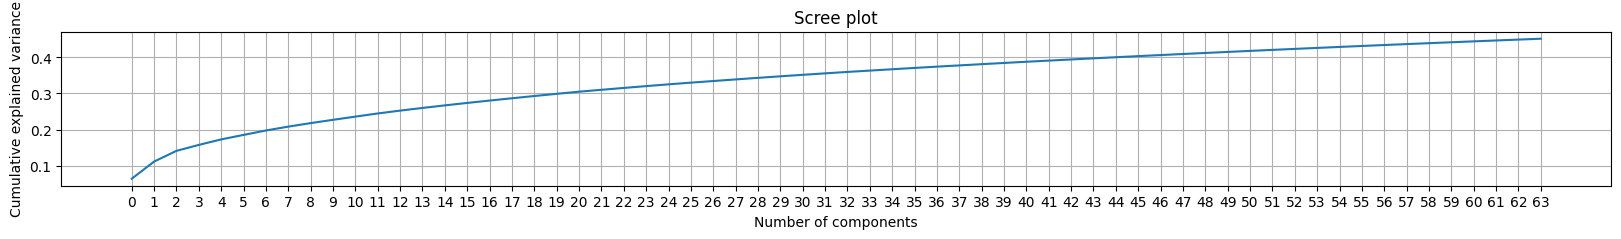

In [14]:
mat_pca = PCA(n_components = 64)

if dataset_name == "hcp":
    indices = indices[indices!=249]
else:
    indices = indices[indices!=863]

pca_feat = mat_pca.fit_transform(vec_matrices[indices])
plt.figure(figsize=(20, 2))
plt.plot(np.cumsum(mat_pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.xticks(np.arange(0, 64, 1))
plt.title('Scree plot')

plt.grid()


In [15]:
ridge_estimator = Ridge(alpha=1)
pca = PCA(n_components=64)
pipe_ridge = Pipeline([('scaler', StandardScaler()), ('pca', pca), ('ridge', ridge_estimator)])

In [16]:
ridge_runs = []
train_ratio = 1.0
for run_id in tqdm(runs):
    print(f"Run {run_id}")
    X_train_idx = np.load(f"{exp_dir}/train_idx_{run_type}{run_id}_train_ratio{train_ratio}.npy")
    X_test_idx = np.load(f"{exp_dir}/test_idx_{run_type}{run_id}_train_ratio{train_ratio}.npy")

    X_train = dataset.isel(index=X_train_idx).matrices.values
    X_train = sym_matrix_to_vec(X_train, discard_diagonal=True)

    X_test = dataset.isel(index=X_test_idx).matrices.values
    X_test = sym_matrix_to_vec(X_test, discard_diagonal=True)

    for target in tqdm(target_dict.keys()):
        if target in predictions.columns:
            print(f"Target {target}")
            
            target_run_perf = {}
            y_train = predictions[(predictions["dataset"] == "train") & (predictions["train_ratio"] == 1.0) & (predictions[run_type] == run_id)][target].values
            y_test = predictions[(predictions["dataset"] == "test") & (predictions["train_ratio"] == 1.0) & (predictions[run_type] == run_id)][target].values


            ridge_fitted = pipe_ridge.fit(X_train, y_train)
            y_test_pred = ridge_fitted.predict(X_test)

            test_corr = custom_corr(y_test, y_test_pred)
            test_error = np.mean(100*np.abs((y_test-y_test_pred)/(y_test + 1e-100)))

            target_run_perf["target"] = target_dict[target]
            # target_run_perf["train_corr"] = train_corr * len(train_error)
            target_run_perf["test_corr"] = test_corr
            # target_run_perf["median_train_mape"] = train_error
            target_run_perf["test_mape"] = test_error
            # target_run_perf["train_mse"] = mean_squared_error(y_train, y_train_pred)
            # target_run_perf["test_mse"] = mean_squared_error(y_test, y_test_pred)
            target_run_perf["train_ratio"] = train_ratio
            target_run_perf[run_type] = run_id

            ridge_runs.append(target_run_perf)
ridge_runs_df = pd.DataFrame(ridge_runs)
ridge_runs_df.to_csv(f"{exp_dir}/pca_ridge_model_perf_runs.csv", index=False)

  0%|          | 0/10 [00:00<?, ?it/s]

Run 1001


Target AngAffect_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target AngHostil_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target AngAggr_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target FearAffect_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target FearSomat_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target Sadness_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target LifeSatisf_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target MeanPurp_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target PosAffect_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target Friendship_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target Loneliness_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target PercHostil_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target PercReject_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target EmotSupp_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target InstruSupp_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target PercStress_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target SelfEff_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)
 10%|█         | 1/10 [00:14<02:13, 14.83s/it]

Run 42


Target AngAffect_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target AngHostil_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target AngAggr_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target FearAffect_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target FearSomat_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target Sadness_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target LifeSatisf_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target MeanPurp_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target PosAffect_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target Friendship_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target Loneliness_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target PercHostil_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target PercReject_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target EmotSupp_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target InstruSupp_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target PercStress_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target SelfEff_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)
 20%|██        | 2/10 [00:29<01:58, 14.85s/it]

Run 54


Target AngAffect_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target AngHostil_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target AngAggr_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target FearAffect_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target FearSomat_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target Sadness_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target LifeSatisf_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target MeanPurp_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target PosAffect_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target Friendship_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target Loneliness_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target PercHostil_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target PercReject_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target EmotSupp_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target InstruSupp_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target PercStress_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target SelfEff_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)
 30%|███       | 3/10 [00:44<01:44, 14.98s/it]

Run 90


Target AngAffect_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target AngHostil_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target AngAggr_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target FearAffect_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target FearSomat_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target Sadness_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target LifeSatisf_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target MeanPurp_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target PosAffect_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target Friendship_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target Loneliness_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target PercHostil_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target PercReject_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target EmotSupp_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target InstruSupp_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target PercStress_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target SelfEff_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)
 40%|████      | 4/10 [00:59<01:30, 15.02s/it]

Run 101


Target AngAffect_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target AngHostil_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target AngAggr_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target FearAffect_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target FearSomat_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target Sadness_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target LifeSatisf_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target MeanPurp_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target PosAffect_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target Friendship_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target Loneliness_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target PercHostil_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target PercReject_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target EmotSupp_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target InstruSupp_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target PercStress_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target SelfEff_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)
 50%|█████     | 5/10 [01:14<01:14, 14.98s/it]

Run 80


Target AngAffect_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target AngHostil_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target AngAggr_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target FearAffect_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target FearSomat_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target Sadness_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target LifeSatisf_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target MeanPurp_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target PosAffect_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target Friendship_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target Loneliness_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target PercHostil_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target PercReject_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target EmotSupp_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target InstruSupp_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target PercStress_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target SelfEff_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)
 60%|██████    | 6/10 [01:29<00:59, 14.88s/it]

Run 422


Target AngAffect_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target AngHostil_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target AngAggr_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target FearAffect_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target FearSomat_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target Sadness_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target LifeSatisf_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target MeanPurp_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target PosAffect_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target Friendship_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target Loneliness_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target PercHostil_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target PercReject_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target EmotSupp_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target InstruSupp_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target PercStress_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target SelfEff_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)
 70%|███████   | 7/10 [01:44<00:44, 14.84s/it]

Run 142


Target AngAffect_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target AngHostil_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target AngAggr_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target FearAffect_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target FearSomat_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target Sadness_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target LifeSatisf_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target MeanPurp_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target PosAffect_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target Friendship_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target Loneliness_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target PercHostil_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target PercReject_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target EmotSupp_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target InstruSupp_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target PercStress_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target SelfEff_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)
 80%|████████  | 8/10 [01:58<00:29, 14.75s/it]

Run 128


Target AngAffect_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target AngHostil_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target AngAggr_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target FearAffect_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target FearSomat_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target Sadness_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target LifeSatisf_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target MeanPurp_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target PosAffect_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target Friendship_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target Loneliness_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target PercHostil_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target PercReject_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target EmotSupp_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target InstruSupp_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target PercStress_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target SelfEff_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)
 90%|█████████ | 9/10 [02:13<00:14, 14.78s/it]

Run 340


Target AngAffect_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target AngHostil_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target AngAggr_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target FearAffect_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target FearSomat_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target Sadness_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target LifeSatisf_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target MeanPurp_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target PosAffect_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target Friendship_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target Loneliness_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target PercHostil_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target PercReject_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target EmotSupp_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target InstruSupp_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target PercStress_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)


Target SelfEff_Unadj


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_88384/2168649317.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  corr = float(pg.corr(y, y_pred, correction = 'bicor')['r'].values)
100%|██████████| 10/10 [02:28<00:00, 14.83s/it]


### Plot Results

In [17]:
dataset_name = "hcp"
exp_name_cog = f"{mode}_redmat_enc_{dataset_name}_{prediction_type}_cog"
exp_name_psy = f"{mode}_redmat_enc_{dataset_name}_{prediction_type}_psy"
perf_cog = pd.read_csv(f"results/{exp_name_cog}/pca_ridge_model_perf_runs.csv")
perf_psy = pd.read_csv(f"results/{exp_name_psy}/pca_ridge_model_perf_runs.csv")

perf_df = pd.concat([perf_cog, perf_psy])
# perf_df["test_mse"].replace([np.inf, -np.inf], 100, inplace=True)
# perf_df["median_train_mape"].replace([np.inf, -np.inf], 100, inplace=True)

mean_perf_df = perf_df.groupby('target')['test_corr'].mean()
sorted_targets = mean_perf_df.sort_values(ascending=False).index
perf_df['target_sorted'] = pd.Categorical(perf_df['target'], categories=sorted_targets)

In [18]:
perf_cog["test_mape"].median()

np.float64(1.717915265957321e+99)

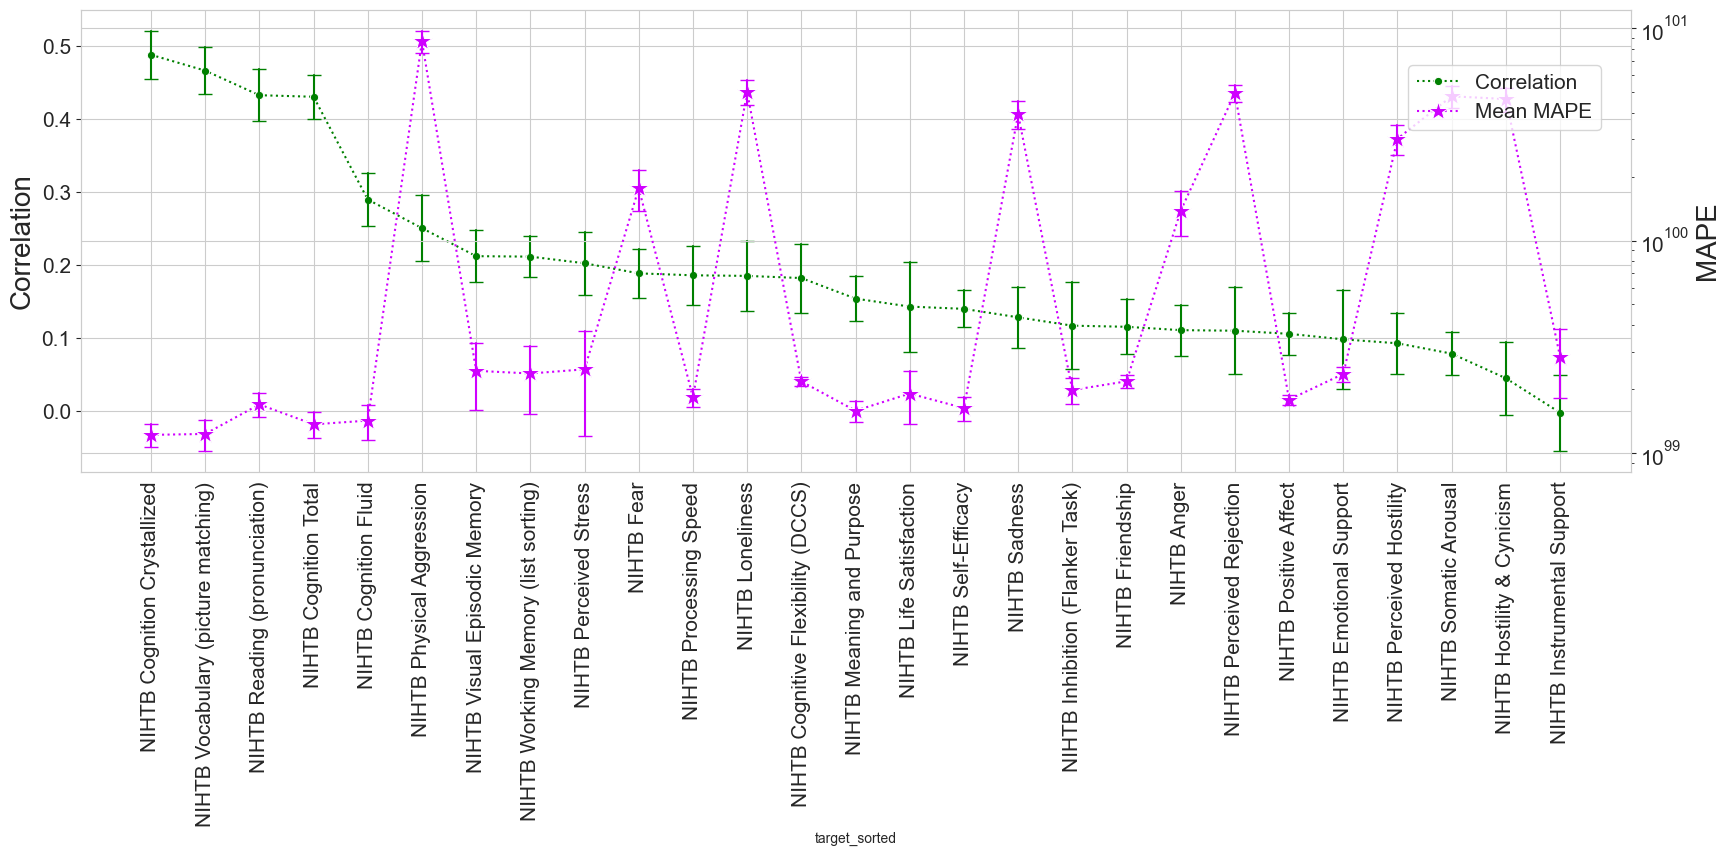

In [20]:
sns.set_style("whitegrid")
fig, ax1 = plt.subplots(figsize=(20, 6))    
ax1 = sns.lineplot(data=perf_df,
                   x="target_sorted",
                   y="test_corr",
                   color="g",
                   label="Correlation",
                   err_style="bars",
                   marker="o",
                   err_kws={'capsize':5},
                   errorbar=("sd", 1),
                    linestyle='dotted',
                   legend=False)
plt.xticks(rotation=90, fontsize=15)
ax2 = ax1.twinx()
sns.lineplot(data=perf_df,
             x="target_sorted",
             y="test_mape",
             ax=ax2,
             color="#CF00FF",
             err_style="bars",
             marker="*",
             errorbar=("sd", 1),
             err_kws={'capsize':5},
             markersize=15,
             linestyle='dotted',
             label="Mean MAPE")

ax1.set_ylabel("Correlation", fontsize=20)
ax2.set_ylabel("MAPE", fontsize=20)
ax2.set(yscale='log')

ax1.tick_params(axis='y', labelsize=15)
ax2.tick_params(axis='y', labelsize=15)

# ax2.set_ylim(0, 100)
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()

plt.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper left", bbox_to_anchor=(0.85, 0.80, 1., .102), fontsize=15)
# plt.savefig(f"figures/pca_ridge_perf_{dataset_name}_test.svg", dpi=300, bbox_inches='tight', format='svg')

In [40]:
np.percentile(np.arange(0, 100), 2.5)

np.float64(2.475)